# LAB1239  Part Two - Analysing -Watson Studio Notebook #1 -
### Analysing weather data using Python/Pandas
#### Version20200504

In [4]:
#Based on NOAA data / Python Book in
#https://dataplatform.cloud.ibm.com/exchange/public/entry/view/a7432f0c29c5bda2fb42749f363bd9ff
# version20200428 -mvk@ca.ibm.com

In [34]:
LABID="??" #Tow digits please <<<< ADJUST YOUR LABID <<<<<<
mynoderedinstance="ws://thinklab"+LABID+".mybluemix.net/ws/myweather1/"
print ("LABID ="+LABID)
print (mynoderedinstance)

LABID =??
ws://thinklab??.mybluemix.net/ws/myweather1/


In [35]:
print("Hello World! - Your LABID = "+LABID)

Hello World! - Your LABID = ??


In [10]:
!ls /

bin  etc   lib	  media  opt   root  sbin  sys	usr
dev  home  lib64  mnt	 proc  run   srv   tmp	var


In [11]:
#Read Data File
import pandas as pd
import io
import requests
import calendar
import json
import matplotlib.pyplot as plt
import seaborn as sns

#IEDINBUR6_weather.csv.zip

url="https://github.com/markusvankempen/ThinkLab1239/blob/master/data/jfk_weather_cleaned_mvk.csv.zip?raw=true"
#s=requests.get(url).content

station ="myPWS"
data_raw=pd.read_csv(url, compression='zip')
#data_raw=pd.read_csv("/Users/mvankempen@ca.ibm.com/Downloads/jfk_weather_cleaned_mvk.csv")
data_raw = data_raw.set_index(pd.DatetimeIndex(data_raw['DATE']))
#data_raw.drop(['DATE'], axis=1, inplace=True)
#data_raw['day'] = data_raw['DATE'].apply(lambda x: x.date())
data_raw['day'] = pd.to_datetime(data_raw['DATE'])

data_raw.head()

,DATE,visibility,dry_bulb_temp_f,wet_bulb_temp_f,dew_point_temp_f,relative_humidity,wind_speed,station_pressure,sea_level_pressure,precip,altimeter_setting,wind_direction_sin,wind_direction_cos,pressure_tendency_incr,pressure_tendency_decr,pressure_tendency_const,day
DATE,,,,,,,,,,,,,,,,,
2010-01-01 01:00:00,2010-01-01 1:00,6.0,33.0,32.0,31.0,92.0,0.0,29.97,29.99,0.01,29.99,0.0,1.0,0,1,0,2010-01-01 01:00:00
2010-01-01 02:00:00,2010-01-01 2:00,6.0,33.0,33.0,32.0,96.0,0.0,29.97,29.99,0.02,29.99,0.0,1.0,0,1,0,2010-01-01 02:00:00
2010-01-01 03:00:00,2010-01-01 3:00,5.0,33.0,33.0,32.0,96.0,0.0,29.97,29.99,0.00,29.99,0.0,1.0,0,1,0,2010-01-01 03:00:00
2010-01-01 04:00:00,2010-01-01 4:00,5.0,33.0,33.0,32.0,96.0,0.0,29.95,29.97,0.00,29.97,0.0,1.0,0,1,0,2010-01-01 04:00:00
2010-01-01 05:00:00,2010-01-01 5:00,5.0,33.0,32.0,31.0,92.0,0.0,29.93,29.96,0.00,29.95,0.0,1.0,0,1,0,2010-01-01 05:00:00


### Checking Data

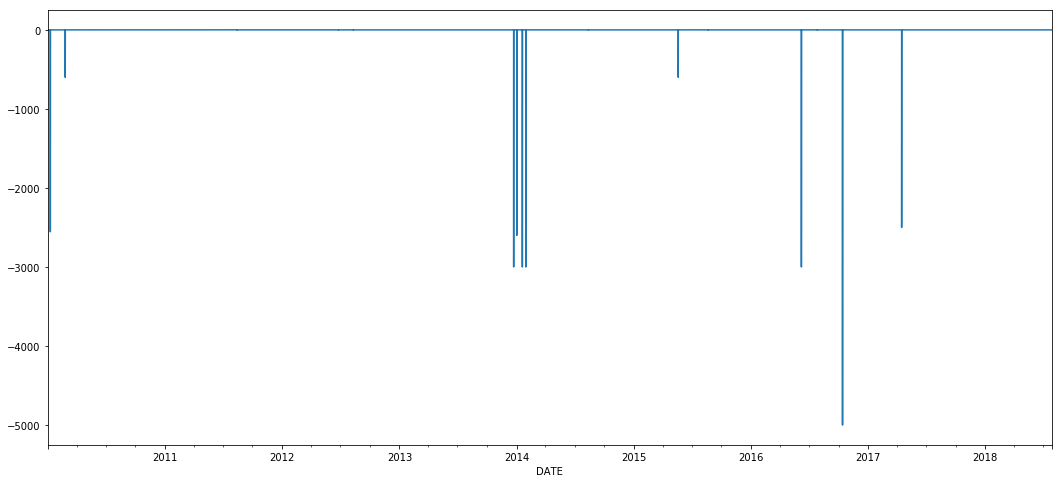

In [12]:
#Check data like precip - we will see some error so we need to adjust them 

plt.figure(figsize=(18,8))
data_raw["precip"].plot() 

# Fixing Data

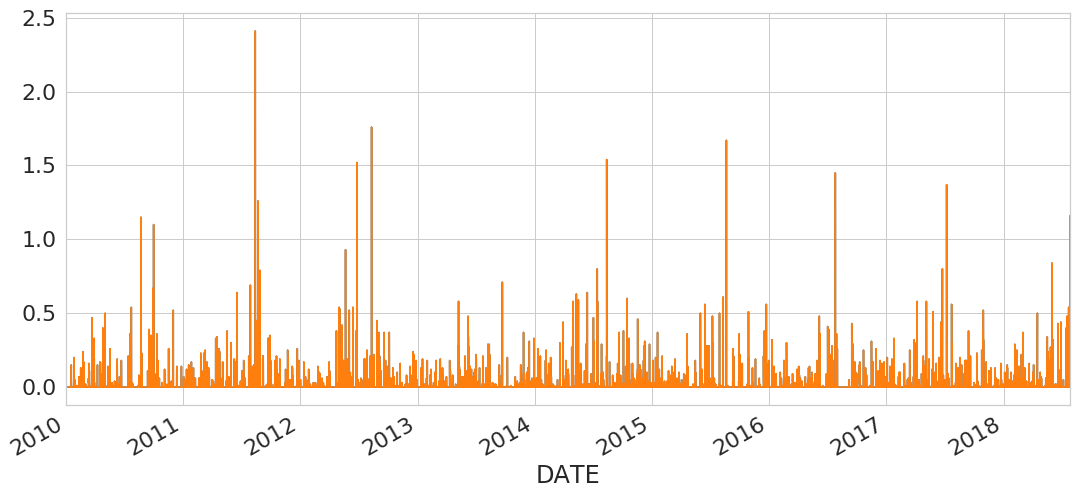

In [31]:
#  Can we fix the outliers ????

plt.figure(figsize=(18,8))
data_raw["precip"].plot() 

#Exercise: 
#We see in above image that there is negative rain on some days hours of the year. 
#In order to get consistency we need to add some code in the Code Cell bellow … Something which simply zeros the entries like: 

###########
data_raw = data_raw[data_raw['precip'] > -500] #Fixing




In [ ]:
#Fixed  plot
data_raw["precip"].plot() 

In [14]:
import calendar 
#hourly_data_renamed['precip'].sum()
# Assign the "day" to every date entry
#hourly_data_renamed['day'] = hourly_data_renamed.apply(lambda x: x.date())
#len(hourly_data_renamed['relative_humidity'] > 96)
#hourly_data_renamed[hourly_data_renamed['raining'] == True].groupby('day').any()
mydata=data_raw
mydata['day'] = mydata.index
mydata['rain'] = data_raw['relative_humidity'] > 96
mydata['day'] = mydata['day'].apply(lambda x: x.date())
mydata['raintotal'] =mydata.groupby('day')['precip'].sum()
mydata['month'] = mydata['day'].apply(lambda x: x.month)
mydata["month_name"] = mydata['month'].apply(lambda x: calendar.month_abbr[x])
mydata.head()

,DATE,visibility,dry_bulb_temp_f,wet_bulb_temp_f,dew_point_temp_f,relative_humidity,wind_speed,station_pressure,sea_level_pressure,precip,...,wind_direction_sin,wind_direction_cos,pressure_tendency_incr,pressure_tendency_decr,pressure_tendency_const,day,rain,raintotal,month,month_name
DATE,,,,,,,,,,,,,,,,,,,,,
2010-01-01 01:00:00,2010-01-01 1:00,6.0,33.0,32.0,31.0,92.0,0.0,29.97,29.99,0.01,...,0.0,1.0,0,1,0,2010-01-01,False,NaN,1,Jan
2010-01-01 02:00:00,2010-01-01 2:00,6.0,33.0,33.0,32.0,96.0,0.0,29.97,29.99,0.02,...,0.0,1.0,0,1,0,2010-01-01,False,NaN,1,Jan
2010-01-01 03:00:00,2010-01-01 3:00,5.0,33.0,33.0,32.0,96.0,0.0,29.97,29.99,0.00,...,0.0,1.0,0,1,0,2010-01-01,False,NaN,1,Jan
2010-01-01 04:00:00,2010-01-01 4:00,5.0,33.0,33.0,32.0,96.0,0.0,29.95,29.97,0.00,...,0.0,1.0,0,1,0,2010-01-01,False,NaN,1,Jan
2010-01-01 05:00:00,2010-01-01 5:00,5.0,33.0,32.0,31.0,92.0,0.0,29.93,29.96,0.00,...,0.0,1.0,0,1,0,2010-01-01,False,NaN,1,Jan


In [15]:
columns_drop = [

    'dew_point_temp_f',

    'sea_level_pressure',
    'altimeter_setting',
    'wind_direction_sin',
    'wind_direction_cos',
    'pressure_tendency_incr',
    'pressure_tendency_decr',
    'pressure_tendency_const'
]
mydata=mydata.drop(columns=columns_drop)
print(len(mydata[mydata.precip >= 0.06]))
#print(len(mydata[mydata.relative_humidity >= 99]))
#mydata['rainh']= if(mydata.relative_humidity > 0.1
#mydata.replace({"rainh": {True: 1, False:0}}, inplace=True)
mydata['rainh']=mydata.precip.apply(lambda x: (x>=0.06),1,0)

mydata["2010-01-17":].head()
#Exercise: Drop the web_bulb_temp_f and the station_pressure columns as well .

1786


,DATE,visibility,dry_bulb_temp_f,wet_bulb_temp_f,relative_humidity,wind_speed,station_pressure,precip,day,rain,raintotal,month,month_name,rainh
DATE,,,,,,,,,,,,,,
2010-01-17 00:00:00,2010-01-17 0:00,10.0,33.0,31.0,82.0,7.0,30.12,0.0,2010-01-17,False,0.64,1,Jan,False
2010-01-17 01:00:00,2010-01-17 1:00,9.0,34.0,32.0,85.0,7.0,30.11,0.0,2010-01-17,False,NaN,1,Jan,False
2010-01-17 02:00:00,2010-01-17 2:00,9.0,31.0,30.0,89.0,0.0,30.09,0.0,2010-01-17,False,NaN,1,Jan,False
2010-01-17 03:00:00,2010-01-17 3:00,9.0,32.0,31.0,88.0,0.0,30.10,0.0,2010-01-17,False,NaN,1,Jan,False
2010-01-17 04:00:00,2010-01-17 4:00,9.0,33.0,32.0,89.0,0.0,30.11,0.0,2010-01-17,False,NaN,1,Jan,False


# Calculating Rain per Day

In [16]:
#
data=mydata.groupby('day')['relative_humidity'].max().reset_index()
data=data.set_index(data['day'])
data.index.name="index"
data['rain_mm']   = pd.Series(mydata.groupby('day')['precip'].sum(), index=data.index)
data['rain_daily_hours']   = pd.Series(mydata.groupby('day')['rainh'].sum(), index=data.index)
data['temp_f_max']= pd.Series(mydata.groupby('day')['dry_bulb_temp_f'].mean(), index=data.index)
#
#
#
print("Records by day since 2010 - 2018-07 ="+str(len(data)))
print("Total Days with data.relative_humidity >= 95  = "+ str(len(data[data.relative_humidity > 95]))) ## use prec/rain
print("Total Days with data.rain_mm > 0.14           = "+ str(len(data[data.rain_mm >= 0.17])))
#
#
data=data.set_index(data['day'])
data.index = pd.to_datetime(data.index)
data.index.name="index"
data['date'] = pd.to_datetime(data['day'])
data['ym'] = data.date.apply(lambda x: x.strftime('%Y%m'))
#
#
#
data['rainy']= data.rain_mm >= 0.15 
data['rainday'] = data.rainy.apply(lambda x: (x>=0.15),1,0)
#
#
#
print("Rainy days in 2017 with  data.rain_mm >= 0.15  = "+str(len(data["2017":"2017"][data.rain_mm >= 0.15])))
print("Rainy days in 2016 with  data.rain_mm >= 0.15 = "+str(len(data["2016":"2016"][data.rain_mm >= 0.17])))
data["2010-01-17":"2012"].head(10)
#Exercise: 
#There are some discrepancies between rain_mm and relative_humidity. Try to get the days of rain_mm and relative_humidity to match up.
#Like … 488 days in 8 years seems to be a good number.


Records by day since 2010 - 2018-07 =3130
Total Days with data.relative_humidity >= 95  = 488
Total Days with data.rain_mm > 0.14           = 490
Rainy days in 2017 with  data.rain_mm >= 0.15  = 63
Rainy days in 2016 with  data.rain_mm >= 0.15 = 51


/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:29: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:30: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


,day,relative_humidity,rain_mm,rain_daily_hours,temp_f_max,date,ym,rainy,rainday
index,,,,,,,,,
2010-01-17,2010-01-17,96.0,0.64,5.0,37.250000,2010-01-17,201001,True,True
2010-01-18,2010-01-18,89.0,0.02,0.0,42.416667,2010-01-18,201001,False,False
2010-01-19,2010-01-19,96.0,0.00,0.0,40.416667,2010-01-19,201001,False,False
2010-01-20,2010-01-20,79.0,0.00,0.0,37.791667,2010-01-20,201001,False,False
2010-01-21,2010-01-21,75.0,0.00,0.0,34.333333,2010-01-21,201001,False,False
2010-01-22,2010-01-22,72.0,0.00,0.0,36.916667,2010-01-22,201001,False,False
2010-01-23,2010-01-23,72.0,0.00,0.0,32.333333,2010-01-23,201001,False,False
2010-01-24,2010-01-24,90.0,0.00,0.0,38.416667,2010-01-24,201001,False,False
2010-01-25,2010-01-25,97.0,0.85,6.0,49.458333,2010-01-25,201001,True,True


### Grouping and Calculating Dry and  Wet days.

In [17]:
#Calucate Wet and Dry days
monthly = pd.DataFrame(data.groupby('ym')['rainy'].value_counts())
monthly.columns = ['Days']
monthly.reset_index(inplace = True)
monthly.columns = ['month', 'Rainy', 'Days']
monthly.replace({"Rainy": {True: "Wet", False:"Dry"}}, inplace=True)
monthly.head()
#
#
ndata=monthly.pivot(index ='month', columns ='Rainy')
#
#
ndata=ndata.droplevel(0, axis=1) 
ndata.reset_index(inplace = True)
ndata=ndata.fillna(0)
dataX=data.merge(ndata, left_on='ym', right_on='month')
dataX.reset_index(inplace = True)

dataX=dataX.set_index(dataX['date'])

dataX.drop(columns='index')
dataX["2010-01-17":"2012"].head(10)

,index,day,relative_humidity,rain_mm,rain_daily_hours,temp_f_max,date,ym,rainy,rainday,month,Dry,Wet
date,,,,,,,,,,,,,
2010-01-17,16,2010-01-17,96.0,0.64,5.0,37.250000,2010-01-17,201001,True,True,201001,29.0,2.0
2010-01-18,17,2010-01-18,89.0,0.02,0.0,42.416667,2010-01-18,201001,False,False,201001,29.0,2.0
2010-01-19,18,2010-01-19,96.0,0.00,0.0,40.416667,2010-01-19,201001,False,False,201001,29.0,2.0
2010-01-20,19,2010-01-20,79.0,0.00,0.0,37.791667,2010-01-20,201001,False,False,201001,29.0,2.0
2010-01-21,20,2010-01-21,75.0,0.00,0.0,34.333333,2010-01-21,201001,False,False,201001,29.0,2.0
2010-01-22,21,2010-01-22,72.0,0.00,0.0,36.916667,2010-01-22,201001,False,False,201001,29.0,2.0
2010-01-23,22,2010-01-23,72.0,0.00,0.0,32.333333,2010-01-23,201001,False,False,201001,29.0,2.0
2010-01-24,23,2010-01-24,90.0,0.00,0.0,38.416667,2010-01-24,201001,False,False,201001,29.0,2.0
2010-01-25,24,2010-01-25,97.0,0.85,6.0,49.458333,2010-01-25,201001,True,True,201001,29.0,2.0


### Check Distribution

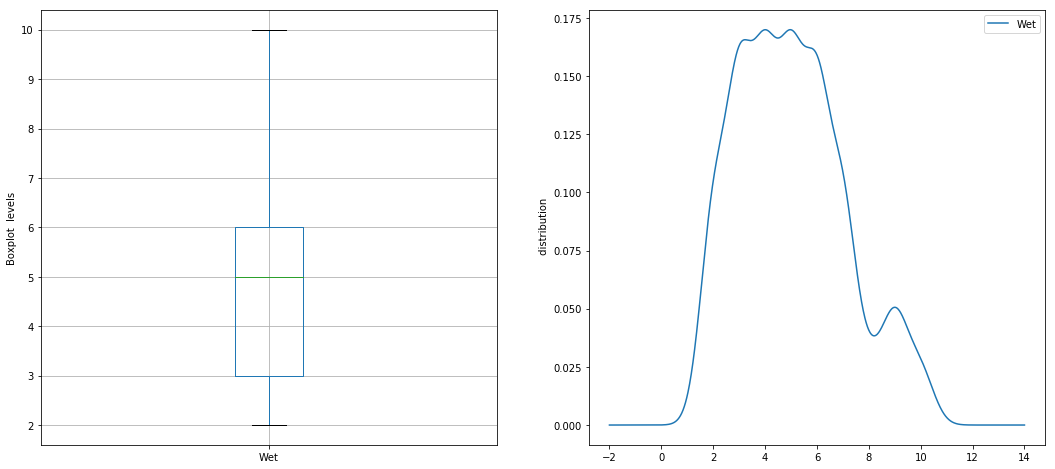

In [18]:
import numpy as np
import matplotlib.pyplot as plt
def plotBoxNdendity(data,col=None):
  if col in data.columns:    
    plt.figure(figsize=(18,8))

    ax1 = plt.subplot(121)
    data.boxplot(col,ax=ax1)
    ax1.set_ylabel('Boxplot  levels', fontsize=10)

    ax2 = plt.subplot(122)
    data[col].plot(ax=ax2,legend=True,kind='density')
    ax2.set_ylabel(' distribution', fontsize=10)

  else:
    print("Column not in the data")
#Exercise: Try multiple plots with different years. 
plotBoxNdendity(dataX[:'2012'],'Wet')



In [19]:
# Excerise  
#Rain in MM/Hours per day -
#plt.figure(figsize=(18,8))
#dataX['2017':'2017']["rain_daily_hours"].plot()
#dataX['2017':'2017']["rain_mm"].mean()

### Creating Monthly Data 

In [20]:
#data.index = pd.to_datetime(data.index, unit='s')
#data['date']=pd.to_datetime(data['date'], infer_datetime_format=True)
#data.index = pd.to_datetime(data.index)
dataM=dataX.resample('M').max(); # monthly
dataM['year'] = dataM['day'].apply(lambda x: x.year)
dataM['month'] = dataM['day'].apply(lambda x: x.month)
dataM["month_name"] = dataM['month'].apply(lambda x: calendar.month_abbr[x])
dataM["temp_c_max"] = round((dataM["temp_f_max"] - 32) * 5/9,2)
dataM=dataM.drop(columns = "relative_humidity")
dataM=dataM.drop(columns = "index")
dataM=dataM.drop(columns = "day")
dataM=dataM.drop(columns = "rain_mm")
dataM=dataM.drop(columns = "rain_daily_hours")
dataM=dataM.drop(columns = "rainday")
dataM=dataM.drop(columns = "ym")
dataM=dataM.drop(columns = "temp_f_max")
dataM=dataM.drop(columns = "rainy")
dataM=dataM.drop(columns = "month")
#dataM=dataM.drop(columns = "temp_c_max")
dataM=dataM.drop(columns = "date")

#dataM[dataM.relative_humidity >= 98].head()
dataM['2017-01':].head()
#Exercise:
#feel free to add or leave some columns ...like average temperature (mean()) or temperature in Fahrenheit


,Dry,Wet,year,month_name,temp_c_max
date,,,,,
2017-01-31,22.0,9.0,2017,Jan,10.51
2017-02-28,25.0,3.0,2017,Feb,14.05
2017-03-31,26.0,5.0,2017,Mar,13.12
2017-04-30,24.0,6.0,2017,Apr,22.29
2017-05-31,25.0,6.0,2017,May,26.78


### Plot the Monthly sample data

Text(0.5, 1.0, '2016 myPWS')

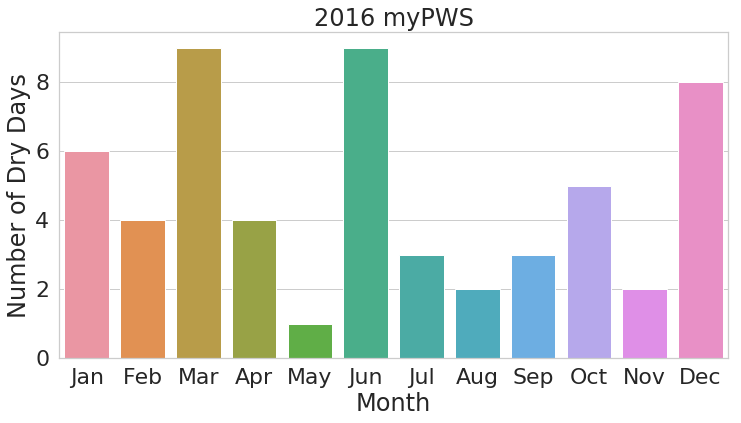

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns
# Monthly plot of rainy days
plt.figure(figsize=(12,6))
sns.set_style("whitegrid")
sns.set_context("notebook", font_scale=2)
sns.barplot(x="month_name", y="Wet",  data=dataM["2015-01":"2015-12"])

plt.xlabel("Month")
plt.ylabel("Number of Dry Days")
plt.title("2016 {}".format(station))
#Exerise display different years / data Elements

### Playground for Query testing
- Test how to get information e.g Dry and Wet from the dataset and covert them into json 

In [22]:
# GetInfo
dataY = dataM.resample('Y').mean(); # yearly averages
dataY.year.count()
getInfo = '{"cmd":"getInfo","tablesize":'+str(len(dataM))+',"years":'+str(dataY.year.count())+'}'; # yearly averages

print(getInfo)


{"cmd":"getInfo","tablesize":103,"years":9}


In [23]:
#getJan2017
datain = {'cmd' : 'getJan2017'}
dry=dataM["2017":"2017"].loc[dataM['month_name'] == 'Apr'].values[0][0]
wet=dataM["2017":"2017"].loc[dataM['month_name'] == 'Apr'].values[0][1]
yy=dataM["2017":"2017"].loc[dataM['month_name'] == 'Apr'].values[0][2]
mm=dataM["2017":"2017"].loc[dataM['month_name'] == 'Apr'].values[0][3]
temp=dataM["2017":"2017"].loc[dataM['month_name'] == 'Apr'].values[0][4]
mvk = {'Wet': wet,'Dry' : dry,"Month" : mm ,"Year":yy}
mvk["cmd"]=datain['cmd']
mvk

{'Wet': 6.0, 'Dry': 24.0, 'Month': 'Apr', 'Year': 2017, 'cmd': 'getJan2017'}

In [27]:
#Get A range
sel= dataM["2017-01":"2017-03"]
mvk=sel.reset_index().to_json(orient='records')
getInfo={"cmd":"cmd","info":[]}
info=json.loads(mvk)  
getInfo['info']=info
getInfo["cmd"]=datain['cmd']    
print(getInfo)
ERROR #FIX by commenting ... just a road block to prevent execution all at once

{'cmd': 'getJan2017', 'info': [{'date': 1485820800000, 'Dry': 22.0, 'Wet': 9.0, 'year': 2017, 'month_name': 'Jan', 'temp_c_max': 10.51}, {'date': 1488240000000, 'Dry': 25.0, 'Wet': 3.0, 'year': 2017, 'month_name': 'Feb', 'temp_c_max': 14.05}, {'date': 1490918400000, 'Dry': 26.0, 'Wet': 5.0, 'year': 2017, 'month_name': 'Mar', 'temp_c_max': 13.12}]}


NameError: name 'ERROR' is not defined

In [28]:
#GetRain
yy="2017"
mm="Jan"
#mm=datain['month']
#yy=datain['year']
# Excerise Change here see above function 
dry=dataM[yy:yy].loc[dataM['month_name'] == mm].values[0][0]
wet=dataM[yy:yy].loc[dataM['month_name'] == mm].values[0][1]
getInfo = {'Wet': wet,'Dry' : dry,"Month" : mm ,"Year":yy}
getInfo["cmd"]=datain['cmd']  
getInfo

{'Wet': 9.0, 'Dry': 22.0, 'Month': 'Jan', 'Year': '2017', 'cmd': 'getJan2017'}

## Connecting to Node-RED
#### Make sure to adjust the the url below with your Node-Red instance

In [29]:
#Create commincaton with Node-RED instance 
#You need to instal the client 1st
!pip install websocket-client
import websocket
import _thread
import time
import json

def on_open(ws):
    print("on open")
    ws.send(mysdata.loc[mysdata['month_name'] == 'Jan'])
    def run(*args):
        for i in range(10000):
            hbeat = '{"cmd":"Python NB HeartBeat"}'
            print("send cmd")
            ws.send(hbeat)
            time.sleep(1000)
            
    _thread.start_new_thread(run, ())

def on_error(ws, error):
    print(error)

def on_close(ws):
    print("closed")
#    start_websocket_listener()
#    ws.send("Watson Studio Listen End")

def on_message(ws, message):
    print(message)
    wet=-1
    kw=0
    dry=-1
    kd=0
    try:
        datain = json.loads(message)
        print(datain['cmd'])
        # do the required stuff
        # add more iformation maybe even the min/max temperature of the year
        
        if (datain['cmd'] == 'hello'): # Add  more infos like numer of year/month
            getInfo = '{"cmd":"hello","message":"python"}'
            print(getInfo)
            ws.send(getInfo)        
        
        if (datain['cmd'] == 'getInfo'): # Add  more infos like numer of year/month
            getInfo = '{"cmd":"getInfo","tablesize":'+str(len(dataM))+'}'
            print(getInfo)
            ws.send(getInfo)
            
        if (datain['cmd'] == 'getJan2017'):          
            dry=dataM["2017":"2017"].loc[dataM['month_name'] == 'Jan'].values[0][0]
            wet=dataM["2017":"2017"].loc[dataM['month_name'] == 'Jan'].values[0][1]
            yy=dataM["2017":"2017"].loc[dataM['month_name'] == 'Jan'].values[0][2]
            mm=dataM["2017":"2017"].loc[dataM['month_name'] == 'Jan'].values[0][3]
            getInfo = {'Wet': wet,'Dry' : dry,"Month" : mm ,"Year":yy}
            getInfo["cmd"]=datain['cmd']    
            print(getInfo)
            ws.send(json.dumps(getInfo))
        #Get Rain for a month Month  in coming {"cmd":"getRain","month":"Feb","year":"2018"}
        if (datain['cmd'] == 'getRain'):  
            mm=datain['month']
            yy=datain['year']
# Excerise Change - here see above function 
            dry=dataM[yy:yy].loc[dataM['month_name'] == mm].values[0][0]
            wet=dataM[yy:yy].loc[dataM['month_name'] == mm].values[0][1]
            getInfo = {'Wet': wet,'Dry' : dry,"Month" : mm ,"Year":yy}
            getInfo["cmd"]=datain['cmd']
#
#            getInfo = {'Wet': wet,'Dry' : dry,"Month" : "FixCode" ,"Year":"FixCode"}
            getInfo["cmd"]=datain['cmd']    
            print(getInfo)
            ws.send(json.dumps(getInfo))
            
        if (datain['cmd'] == 'getRange'):  
            startym=datain['start'] 
            endym=datain['end'] 
            sel= dataM[startym:endym]
            mvk=sel.reset_index().to_json(orient='records')
            getInfo={"cmd":"cmd","info":[]}
            info=json.loads(mvk)  
            getInfo['info']=info
            getInfo["cmd"]=datain['cmd']    
            print(getInfo)
            ws.send(json.dumps(getInfo))
            
        if (datain['cmd'] == 'getTemp'):  
            yy=datain['year'] 
            mm=datain['month'] 
            temp=dataM[yy:yy].loc[dataM['month_name'] == mm].values[0][4]
            getInfo = {'Temp' :temp,"Month" : mm ,"Year":yy}
            getInfo["cmd"]=datain['cmd']    
            print(getInfo)
            ws.send(json.dumps(getInfo))            
        if (datain['cmd'] == 'getAll'): 
            mysdata.to_json()
       
            
    except Exception as e:
        print("Error -  no json  / no  valid command?")
        print(e)
####   ws://thhttps://dataplatform.cloud.ibm.com/projects/a06017fe-7ff2-4389-9c46-128ae7a8b49d?context=wdpinklab2020nr.mybluemix.net/ws/myweather/"
#### use your own isntance 
def start_websocket_listener():
    #websocket.enableTrace(True)
    ws = websocket.WebSocketApp(mynoderedinstance, #<<<<<<< ADJUST with your LABID
                              on_message = on_message,
                              on_error = on_error,
                              on_close = on_close)
    print("connecting")
   # ws.send("Watson Studio Listen open")
    ws.on_open = on_open
    ws.run_forever()

start_websocket_listener() 

     |████████████████████████████████| 204kB 18.5MB/s eta 0:00:01
connecting
on open
{"cmd":"hello"}
hello
{"cmd":"hello","message":"python"}
{"cmd":"getInfo","month":"Apr"}
getInfo
{"cmd":"getInfo","tablesize":103}
{"cmd":"getTemp","month":"Mar","year":"2018"}
getTemp
{'Temp': 9.95, 'Month': 'Mar', 'Year': '2018', 'cmd': 'getTemp'}
{"cmd":"getJan2017"}
getJan2017
{'Wet': 9.0, 'Dry': 22.0, 'Month': 'Jan', 'Year': 2017, 'cmd': 'getJan2017'}
{"cmd":"getRain","month":"Feb","year":"2018"}
getRain
{'Wet': 10.0, 'Dry': 18.0, 'Month': 'Feb', 'Year': '2018', 'cmd': 'getRain'}
{"cmd":"getRain","month":"Jan","year":"2017"}
getRain
{'Wet': 9.0, 'Dry': 22.0, 'Month': 'Jan', 'Year': '2017', 'cmd': 'getRain'}
{"cmd":"getRange","start":"2017-01","end":"2017-03"}
getRange
{'cmd': 'getRange', 'info': [{'date': 1485820800000, 'Dry': 22.0, 'Wet': 9.0, 'year': 2017, 'month_name': 'Jan', 'temp_c_max': 10.51}, {'date': 1488240000000, 'Dry': 25.0, 'Wet': 3.0, 'year': 2017, 'month_name': 'Feb', 'temp_c_max':

In [27]:
### Start with  Part Two

In [28]:
print("Hello World!")

Hello World!


In [ ]:
# version20200428 -mvk@ca.ibm.com